# Supplementary Figure 2. Comparing efficacy calculations for 1gSLT and Male Wolbachia release

Author: Katie Tiley (katherine.tiley@lshtm.ac.uk) <br>
Date: 08 Nov 22 <br>
<br>
Note: in the code RIDL refers to 1gSLT, and IIT refers to Male Wolbachia release

In [75]:
from scipy.integrate import odeint
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
from scipy import integrate as sp
import seaborn as sns
from tabulate import tabulate
import pandas as pd
import os

### 1. Set up model
Parameters:

In [76]:
# MOSQUITO
alphaO = 0.5  # rate that eggs hatch into larvae
alphaL = 0.18  # rate that larvae pupate
alphaP = 1  # rate that pupae eclose
phi = 500*(1/14)    # number eggs laid per mosquito per day
muO = 0.01    # daily death rate of eggs
muL = 0.1*alphaL    # daily death rate of larvae
muP = 0.1*alphaP     # pupae death rate
muM = 1/14     # adult mosquito death rate
muF = 1/14     # adult female mosquito death rate

# density-dependence via Bellows 1981:
AA = 1   # determines the density at which mortality remains proportionate
BB = 0.5   # determines the 'abruptness' of density-dependence

# WOLBACHIA
fCI = 0.012   # prop of cytoplasmic incompatibility that fails 'sigma'
MT = 0 #0.11    # prop of wolbachia females that don't successfully maternally transfer 'omega'
c = 0.5      # mating competitiveness of released wolbachia males
cv = 0.128   #coverage of adulticide
e = 1.2      # relative mortality of wolbachia adults compared to wild adults
RR = 0.02915       # release ratio of wolbachia eggs to wild type eggs
RRsupp = 1      # release ratio of wolbachia eggs to wild type eggs for suppression techniques

RRsupp = 10 # variable later but essential parameter for model check

Initial conditions:
(equilibrium values previously defined in Supp)

In [77]:
O0 = 15947.608023052446
OW0 = 0
rOW0 = 0
OS0 = 0
L0 = 40271.71074193975
LW0 = 0
rLW0 = 0
LS0 = 0
P0 = 32.67541200187585
PW0 = 0
rPW0 = 0
PS0 = 0
M0 = 228.72754035145144
MW0 = 0
MS0 = 0
F0 = 228.72754035145144
FW0 = 0

Wolbachia release function:

In [78]:
start_wol = 200

def pulseN(t, start_wol=start_wol, releasenumber=5, frequency=14):    
    for i in range(0,releasenumber,1):
        if round(t) == start_wol + (frequency*i):
            return 0 #O0
    else:
        return 0

Suppression functions:

In [79]:
# IIT

def IIT(t, releasenumber=5, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

In [80]:
# SIT / RIDL

switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=1, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

In [81]:
# Environmental management

start_em = 193
stop_em = 200
em_eff = 1 #0.526

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [82]:
# Larvicides (e.g. guppies)

start_lv = 193
stop_lv = 200
lv_eff = 1 #5.95

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [83]:
# Adulticide

h = [] #needed to set adulticide pulses
for i in range(0, -1, -1):
    h.append((start_wol-7) - (7*i))
#h = start_wol

def ad(t):    
    ad_eff = 0 #4.9
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01: # and round(t) < h[1]: # un-comment according to number of releases
        return 0
#    elif round(t) > h[1]+0.01 and round(t) < h[2]:
#        return 0
#    elif round(t) > h[2]+0.01 and round(t) < h[3]:
#        return 0
#    elif round(t) > h[3]+0.01 and round(t) < h[4]:
#        return 0
#    elif round(t) > h[4]+0.01 and round(t) < h[5]:
#        return 0
#    elif round(t) > h[5]+0.01 and round(t) < h[6]:
#        return 0
#    elif round(t) > h[6]+0.01 and round(t) < h[7]:
#        return 0
#    elif round(t) > h[7]+0.01 and round(t) < h[8]:
#        return 0
#    elif round(t) > h[8]+0.01 and round(t) < h[9]:
#        return 0
#    elif round(t) > h[9]+0.01:
#        return 0
    else:
        return ad_eff

Model:

In [84]:
def deriv(y, t, fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch):
    
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = y
    
    #MOSQUITOES
    
    allfemales = 1+F+FW
    allmales = 1+M+MW+(MS*c)
    
    F_nothing = F + FW*MT 
    M_nothing = M + MW*fCI 
    
    F_wol = FW*(1-MT)
    
    #Eggs
    dOdt = em(t) * phi * F_nothing * M_nothing/allmales - alphaO*O - lv(t)*muO*O # eggs laid * females no-wol * (males no_wol / all males) (aka prop no-wol males)
    dOWdt = em(t) * phi * F_wol * (M+MW)/allmales - alphaO*OW - lv(t)*muO*OW 
    drOWdt = pulseN(t)*RR - alphaO*rOW - muO*rOW
    dOSdt = phi * allfemales * (MS*c)/allmales - alphaO*OS - muO*OS
    
    #Larvae
    dLdt =  alphaO*O - alphaL*L - lv(t)*muL*L
    dLWdt = alphaO*OW - alphaL*LW - lv(t)*muL*LW
    drLWdt = alphaO*rOW - alphaL*rLW - muL*rLW
    dLSdt = switch*alphaO*OS - alphaL*LS - muL*LS
    
    #Pupae 
    dPdt =  alphaL*(L/(1+((AA*(L+LW+LS))**BB))) - alphaP*P - lv(t)*muP*P 
    dPWdt = alphaL*(LW/(1+((AA*(L+LW+LS))**BB))) - alphaP*PW - lv(t)*muP*PW
    drPWdt = alphaL*(rLW/(1+((AA*(rLW))**BB))) - alphaP*rPW - muP*rPW 
    dPSdt = alphaL*(LS/(1+((AA*(L+LW+LS))**BB))) - alphaP*PS - muP*PS
        
    #Adult
    dMdt =  .5*alphaP*P - muM*M - ad(t)*M*cv
    dMWdt = IIT(t)*RRsupp + .5*alphaP*(PW+rPW) - muM*1.2*MW - ad(t)*MW*cv
    dMSdt = SIT(t)*RRsupp - muM*1.2*MS #+ .5*alphaP*PS remove for 1gSLT
    
    dFdt =  .5*alphaP*P - muF*F - ad(t)*F*cv
    dFWdt = .5*alphaP*(PW+rPW) - muF*1.2*FW - ad(t)*FW*cv

    return dOdt, dOWdt, drOWdt, dOSdt, dLdt, dLWdt, drLWdt, dLSdt, dPdt, dPWdt, drPWdt, dPSdt, dMdt, dMWdt, dMSdt, dFdt, dFWdt

Model prerequisites:

In [85]:
t = np.linspace(0, 1500, 1501) # grid of time points (in days)
y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # initial condition vector

Run model:

In [86]:
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

Visual check all suppression and Wolbachia functions are switched off:
(should see horizontal lines)

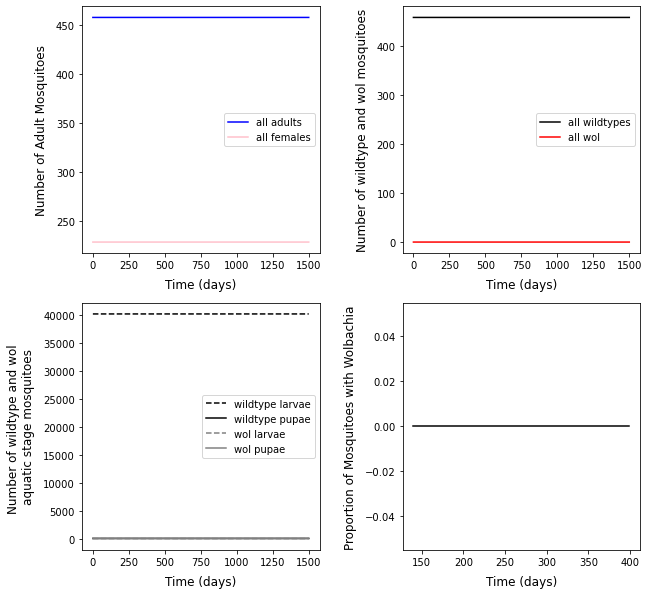

In [87]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10,10])

ax1.plot(t, F+FW+M+MW, 'blue', label='all adults')
ax1.plot(t, F+FW, 'pink', label='all females')
ax1.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax1.set_ylabel("Number of Adult Mosquitoes",fontsize=12, labelpad=8)
ax1.legend()

ax2.plot(t, M+F, 'black', label='all wildtypes')
ax2.plot(t, MW+FW, 'red', label='all wol')
ax2.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax2.set_ylabel("Number of wildtype and wol mosquitoes",fontsize=12, labelpad=8)
ax2.legend()

ax3.plot(t, L, 'black', linestyle='dashed', label='wildtype larvae')
ax3.plot(t, P, 'black', label='wildtype pupae')
ax3.plot(t, LW, 'grey', linestyle='dashed', label='wol larvae')
ax3.plot(t, PW, 'grey', label='wol pupae')
ax3.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax3.set_ylabel("Number of wildtype and wol \naquatic stage mosquitoes",fontsize=12, labelpad=8)
ax3.legend()

ax4.plot(t[140:400], (MW[140:400]+FW[140:400])/(MW[140:400]+FW[140:400]+M[140:400]+F[140:400]), 'black')
plt.xticks([150,200,250,300,350,400])
ax4.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax4.set_ylabel("Proportion of Mosquitoes with Wolbachia",fontsize=12, labelpad=8)


plt.subplots_adjust(wspace=.35)

### 2. RIDL efficacy
Import RRsupp values

In [88]:
filepath = os.path.abspath(os.getcwd())
RIDL_df = pd.read_csv(f'{filepath}/RIDL_df.csv')
#print(RIDL_df)

Switch on RIDL

In [89]:
# SIT / RIDL

switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

a) 20%

In [90]:
RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 20, 'RRsupp value'])
RRsupp = RRsupp[0]

In [91]:
#save results
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

RIDL20 = M+F

b) 50%

In [92]:
RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0]

In [93]:
#save results
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

RIDL50 = M+F 

c) 80%

In [94]:
RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 80, 'RRsupp value'])
RRsupp = RRsupp[0]

In [95]:
#save results
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

RIDL80 = M+F 

d) literature, 45%

In [96]:
RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 45, 'RRsupp value'])
RRsupp = RRsupp[0]

In [97]:
#save results
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

RIDL45 = M+F 

In [98]:
RIDL_delay = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 45, 'Maximum delayed efficacy'])
round(RIDL_delay[0],2)

51.67

Switch off RIDL:

In [99]:
# SIT / RIDL

switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=1, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

### 3. IIT efficacy
Import RRsupp values:

In [100]:
filepath = os.path.abspath(os.getcwd())
IIT_df = pd.read_csv(f'{filepath}/IIT_df_01-02-24.csv')
#print(IIT_df)

Switch on IIT:

In [101]:
# IIT

def IIT(t, releasenumber=5, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

a) 20%

In [102]:
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 20, 'RRsupp value'])
RRsupp = RRsupp[0]

In [103]:
#save results
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

IIT20 = M+F

b) 50%

In [104]:
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0]

In [105]:
#save results
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

IIT50 = M+F

c) 80%

In [106]:
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 80, 'RRsupp value'])
RRsupp = RRsupp[0]

In [107]:
#save results
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

IIT80 = M+F

d) 60%

In [108]:
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 65, 'RRsupp value'])
RRsupp = RRsupp[0]

In [109]:
#save results
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

IIT60 = M+F

In [110]:
IIT_delay = list(IIT_df.loc[IIT_df['Target efficacy'] == 65, 'Maximum delayed efficacy'])
round(IIT_delay[0],2)

67.41

Switch off IIT:

In [111]:
# IIT

def IIT(t, releasenumber=5, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

### 3. Combine into final figure

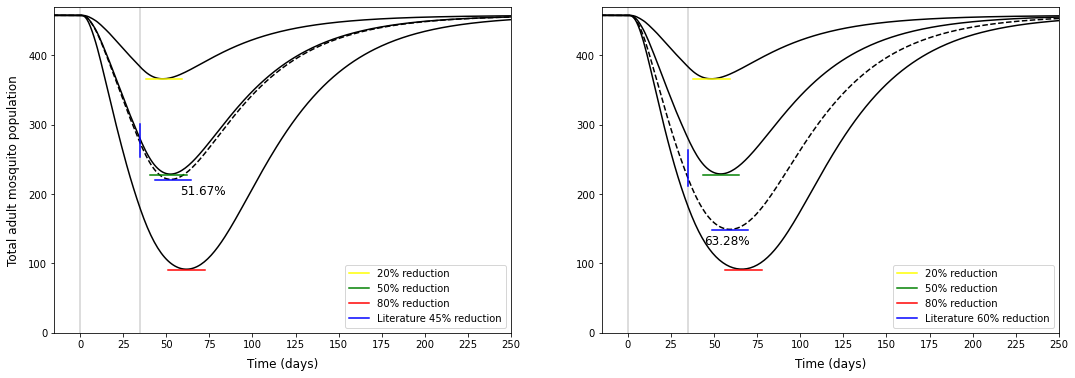

In [112]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(18, 6))


ax1.axvline(x=200, color="lightgrey", linestyle="solid")
ax1.axvline(x=165, color="lightgrey", linestyle="solid")

ax1.plot(t, RIDL20, color='black')
ax1.plot(t, RIDL50, color='black')
ax1.plot(t, RIDL80, color='black')
ax1.plot(t, RIDL45, color='black', linestyle='dashed')

ax1.axhline(y=min(RIDL20)-1, xmin=0.2, xmax=0.28, color="yellow", label="20% reduction")
ax1.axhline(y=min(RIDL50)-1, xmin=0.21, xmax=0.29, color="green", label="50% reduction")
ax1.axhline(y=min(RIDL80)-1, xmin=0.25, xmax=0.33, color="red", label="80% reduction")
ax1.axhline(y=min(RIDL45)-1, xmin=0.22, xmax=0.3, color="blue", label="Literature 45% reduction")
ax1.axvline(x=200, ymax=0.64, ymin=0.54, color="blue")
ax1.text(min(RIDL45)+2, min(RIDL45)-22, '51.67%', fontsize=12)

ax1.set_xlim(150,400)
ax1.set_ylim(0,470)
ax1.set_xticks(range(165,440,25), range(0,275,25))
ax1.set_xlabel("Time (days)", fontsize=12, labelpad=8)
ax1.set_ylabel("Total adult mosquito population", fontsize=12, labelpad=8)
ax1.legend(loc='lower right')

#-----------------

ax2.axvline(x=200, color="lightgrey", linestyle="solid")
ax2.axvline(x=165, color="lightgrey", linestyle="solid")

ax2.plot(t, IIT20, color='black')
ax2.plot(t, IIT50, color='black')
ax2.plot(t, IIT80, color='black')
ax2.plot(t, IIT60, color='black', linestyle='dashed')

ax2.axhline(y=min(IIT20)-1, xmin=0.2, xmax=0.28, color="yellow", label="20% reduction")
ax2.axhline(y=min(IIT50)-1, xmin=0.22, xmax=0.3, color="green", label="50% reduction")
ax2.axhline(y=min(IIT80)-1, xmin=0.27, xmax=0.35, color="red", label="80% reduction")
ax2.axhline(y=min(IIT60)-1, xmin=0.24, xmax=0.32, color="blue", label="Literature 60% reduction")
ax2.axvline(x=200, ymax=0.56, ymin=0.45, color="blue")
ax2.text(min(IIT60)+60, min(IIT60)-22, '63.28%', fontsize=12)

ax2.set_xlim(150,400)
ax2.set_ylim(0,470)
ax2.set_xticks(range(165,440,25), range(0,275,25))
ax2.set_xlabel("Time (days)", fontsize=12, labelpad=8)
#ax2.set_ylabel("Total adult mosquito population", fontsize=12, labelpad=8)
ax2.legend(loc='lower right')


#plt.savefig('SFigure2.jpeg', dpi=600, bbox_inches='tight',)

### SIT delayed efficacy

Import RRsupp values

In [113]:
filepath = os.path.abspath(os.getcwd())
SIT_df = pd.read_csv(f'{filepath}/SIT_df_01-02-24.csv')
#print(RIDL_df)

Switch on RIDL

In [114]:
# SIT / RIDL

switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

a) 20%

In [115]:
RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 20, 'RRsupp value'])
RRsupp = RRsupp[0]
#save results
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

SIT20 = M+F

b) 50%

In [116]:
RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0]
#save results
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

SIT50 = M+F 

c) 80%

In [117]:
RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 80, 'RRsupp value'])
RRsupp = RRsupp[0]
#save results
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

SIT80 = M+F 

d) literature, 49%

In [118]:
RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 49, 'RRsupp value'])
RRsupp = RRsupp[0]
#save results
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

SIT49 = M+F

In [119]:
SIT_delay = list(SIT_df.loc[SIT_df['Target efficacy'] == 49, 'Maximum delayed efficacy'])
round(SIT_delay[0],2)

53.99

Switch off SIT:

In [120]:
# SIT / RIDL

switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=1, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

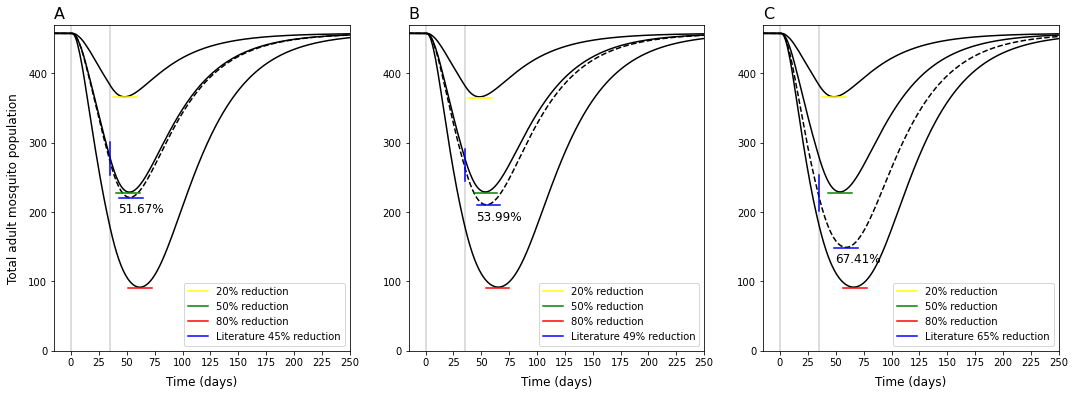

In [133]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(18, 6))


ax1.axvline(x=200, color="lightgrey", linestyle="solid")
ax1.axvline(x=165, color="lightgrey", linestyle="solid")

ax1.plot(t, RIDL20, color='black')
ax1.plot(t, RIDL50, color='black')
ax1.plot(t, RIDL80, color='black')
ax1.plot(t, RIDL45, color='black', linestyle='dashed')

ax1.axhline(y=min(RIDL20)-1, xmin=0.2, xmax=0.28, color="yellow", label="20% reduction")
ax1.axhline(y=min(RIDL50)-1, xmin=0.21, xmax=0.29, color="green", label="50% reduction")
ax1.axhline(y=min(RIDL80)-1, xmin=0.25, xmax=0.33, color="red", label="80% reduction")
ax1.axhline(y=min(RIDL45)-1, xmin=0.22, xmax=0.3, color="blue", label="Literature 45% reduction")
ax1.axvline(x=200, ymax=0.64, ymin=0.54, color="blue")
ax1.text(min(RIDL45)-14, min(RIDL45)-22, '51.67%', fontsize=12)

ax1.set_xlim(150,400)
ax1.set_ylim(0,470)
ax1.set_xticks(range(165,440,25), range(0,275,25))
ax1.set_xlabel("Time (days)", fontsize=12, labelpad=8)
ax1.set_ylabel("Total adult mosquito population", fontsize=12, labelpad=8)
ax1.legend(loc='lower right')
ax1.set_title("A", loc='left', fontdict={'fontsize':16})

#-----------------

ax2.axvline(x=200, color="lightgrey", linestyle="solid")
ax2.axvline(x=165, color="lightgrey", linestyle="solid")

ax2.plot(t, SIT20, color='black')
ax2.plot(t, SIT50, color='black')
ax2.plot(t, SIT80, color='black')
ax2.plot(t, SIT49, color='black', linestyle='dashed')

ax2.axhline(y=min(SIT20)-1, xmin=0.2, xmax=0.28, color="yellow", label="20% reduction")
ax2.axhline(y=min(SIT50)-1, xmin=0.22, xmax=0.3, color="green", label="50% reduction")
ax2.axhline(y=min(SIT80)-1, xmin=0.26, xmax=0.34, color="red", label="80% reduction")
ax2.axhline(y=min(SIT49)-1, xmin=0.23, xmax=0.31, color="blue", label="Literature 49% reduction")
ax2.axvline(x=200, ymax=0.62, ymin=0.52, color="blue")
ax2.text(min(SIT49), min(SIT49)-22, '53.99%', fontsize=12)

ax2.set_xlim(150,400)
ax2.set_ylim(0,470)
ax2.set_xticks(range(165,440,25), range(0,275,25))
ax2.set_xlabel("Time (days)", fontsize=12, labelpad=8)
#ax2.set_ylabel("Total adult mosquito population", fontsize=12, labelpad=8)
ax2.legend(loc='lower right')
ax2.set_title("B", loc='left', fontdict={'fontsize':16})

#-----------------

ax3.axvline(x=200, color="lightgrey", linestyle="solid")
ax3.axvline(x=165, color="lightgrey", linestyle="solid")

ax3.plot(t, IIT20, color='black')
ax3.plot(t, IIT50, color='black')
ax3.plot(t, IIT80, color='black')
ax3.plot(t, IIT60, color='black', linestyle='dashed')

ax3.axhline(y=min(IIT20)-1, xmin=0.2, xmax=0.28, color="yellow", label="20% reduction")
ax3.axhline(y=min(IIT50)-1, xmin=0.22, xmax=0.3, color="green", label="50% reduction")
ax3.axhline(y=min(IIT80)-1, xmin=0.27, xmax=0.35, color="red", label="80% reduction")
ax3.axhline(y=min(IIT60)-1, xmin=0.24, xmax=0.32, color="blue", label="Literature 65% reduction")
ax3.axvline(x=200, ymax=0.54, ymin=0.43, color="blue")
ax3.text(min(IIT60)+65, min(IIT60)-22, '67.41%', fontsize=12)

ax3.set_xlim(150,400)
ax3.set_ylim(0,470)
ax3.set_xticks(range(165,440,25), range(0,275,25))
ax3.set_xlabel("Time (days)", fontsize=12, labelpad=8)
#ax3.set_ylabel("Total adult mosquito population", fontsize=12, labelpad=8)
ax3.legend(loc='lower right')
ax3.set_title("C", loc='left', fontdict={'fontsize':16})

#plt.savefig('SFigure2_01-02-24.jpeg', dpi=600, bbox_inches='tight',)